# Fruit Freshness CNN

## 1. Introduction

This notebook contains **Convolutional Neural Network (CNN)** using PyTorch to classify fruit images based on their freshness. Two different CNN models are used, `a CNN built from scratch` and `a pre-trained ResNet model`. Both models are designed for image classification, with the goal of identifying whether a friut is fresh or rotten.

Using the Fruit Freshness Dataset, which contains images of various fruits in both fresh and rotten states, the main objective of this project is to develop a CNN model capable of accurately classifying fruits and determining their freshness state.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import random
import os
from PIL import Image
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

# For reproducing similar results
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Processing image path

Checking through the dataset directory, images are collected along with their corresponding fruit types and freshness states. This information is stored in a list of dictionaries, which is then converted into a Pandas DataFrame for easier access and manipulation for PyTorch.

In [2]:
path = "drive/My Drive/fruit_freshness_dataset/Data"

In [3]:
fruits = ["Apple", "Banana", "Strawberry"]
states = ["Fresh", "Rotten"]
data_list = []
size = (128, 128) # For resizing images into uniform size

# Processing image paths and loading images into a dataframe
for fruit in fruits:
  for state in states:
    folder = os.path.join(path, fruit, state)
    for img_file in os.listdir(folder):
      img = Image.open(os.path.join(folder, img_file)).convert("RGB").resize(size)
      data_list.append({"image": img,
                        "fruit": fruit,
                        "state": state})
df = pd.DataFrame(data_list)

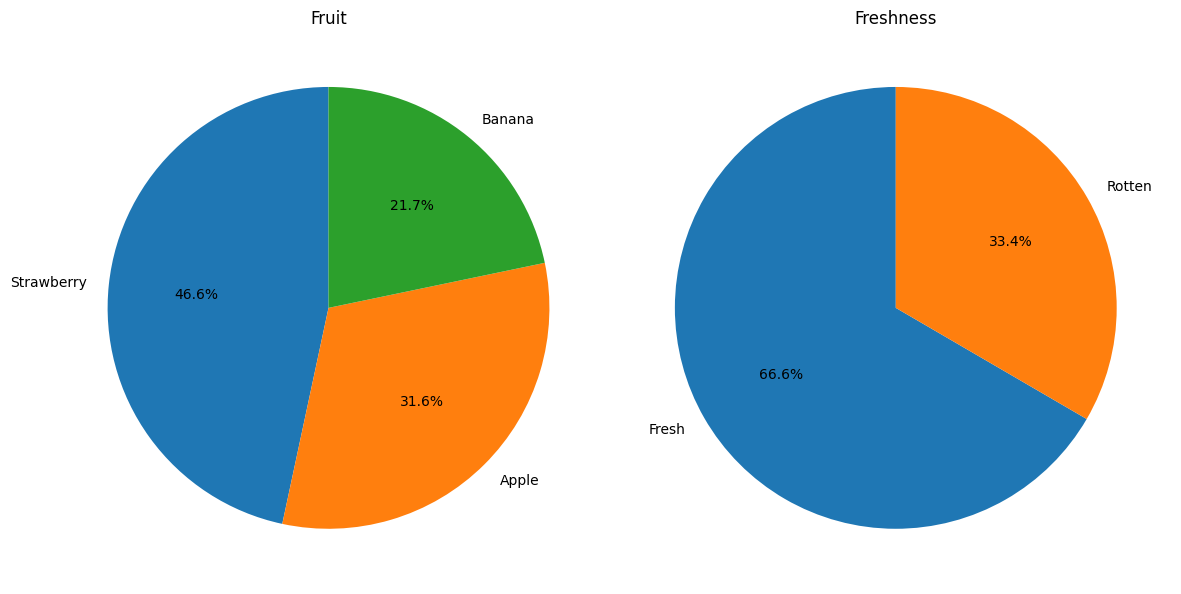

In [4]:
# Pie chart for fruit distribution
plt.figure(figsize=(12, 6))
fruit_counts = df['fruit'].value_counts()
plt.subplot(1, 2, 1)
plt.pie(fruit_counts.values, labels=fruit_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Fruit')

# Pie chart for freshness distribution
state_counts = df['state'].value_counts()
plt.subplot(1, 2, 2)
plt.pie(state_counts.values, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Freshness')

plt.tight_layout()
plt.show()

## 3. Pre-processing

In [5]:
# Transform compose converts images to tensor and normalizes them, preparing them for model input
transform = transforms.Compose([transforms.ToTensor(), # Converts image to tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizes tensor with mean and std
                                                     std=[0.229, 0.224, 0.225])])

# Transform function to apply transformations to the images. Receives the image column from dataframe, which then applies the transform to each image using transpose.Compose
def img_trans(dataset, transform):
  img_transform = []
  for img in dataset:
    img_transform.append(transform(img))
  return torch.stack(img_transform) # Combines list of tensors into single batched tensor

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
## Encoding strings into int values
## Multi-label target: Fruit and state

state_enc = LabelEncoder() # Fruit state encoder
fruit_enc = LabelEncoder() # Fruit encoder
df["state"] = state_enc.fit_transform(df["state"])
df["fruit"] = fruit_enc.fit_transform(df["fruit"])

### 3.1 Splitting train and test

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
feature = df.drop(columns = ["state"])
target = df["state"]

X_train, X_test, y_train, y_test = train_test_split(feature,
                                                    target,
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size=0.2)

In [10]:
help_ = img_trans(X_train["image"], transform)
print(X_train["image"].shape)
print(help_.shape)

(452,)
torch.Size([452, 3, 128, 128])


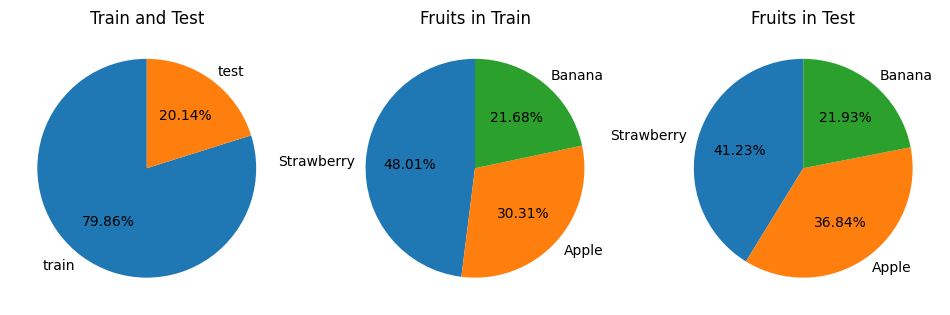

In [11]:
train_ = X_train["fruit"].value_counts()
test_ = X_test["fruit"].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(12, 6))

axes[0].pie([len(X_train), len(X_test)], labels=["train", "test"], autopct='%1.2f%%', startangle=90)
axes[0].set_title("Train and Test")

axes[1].pie(train_, labels=fruit_enc.inverse_transform(train_.index.tolist()), autopct='%1.2f%%', startangle=90)
axes[1].set_title("Fruits in Train")

axes[2].pie(test_, labels=fruit_enc.inverse_transform(test_.index.tolist()), autopct='%1.2f%%', startangle=90)
axes[2].set_title("Fruits in Test")

plt.show()

In [12]:
### Quick test to confirm the method
__ = X_test["fruit"].value_counts().to_list()
___prob = __[0] / sum(__)
__fruit = fruit_enc.inverse_transform([2, 0, 1])
print(X_train["fruit"].value_counts())
print(__fruit)
print(f"\n{__fruit[0]}{___prob * 100: .2f}")

fruit
2    217
0    137
1     98
Name: count, dtype: int64
['Strawberry' 'Apple' 'Banana']

Strawberry 41.23


### 3.2 Image to tensor


In [13]:
# Calling img_trans function to convert train and test images to stacked tensors
# Conversion of image to tensor
X_train_trans = img_trans(X_train["image"], transform)
X_test_trans = img_trans(X_test["image"], transform)

In [14]:
print(X_train["image"].shape)
print(X_train_trans.shape)

(452,)
torch.Size([452, 3, 128, 128])


### 3.3 Labels to tensor

In [15]:
# Conversion of the fruit and state into tensors, which is required for PyTorch models. Both train and test values are converted into tensors
# Conversion of encoded [fruit, state] into tensors
train_fruit_labels = torch.tensor(X_train['fruit'].values).long().to(device)
train_state_labels = torch.tensor(y_train.values).float().unsqueeze(1).to(device)
test_fruit_labels = torch.tensor(X_test['fruit'].values).long().to(device)
test_state_labels = torch.tensor(y_test.values).float().unsqueeze(1).to(device)

In [16]:
train_state_labels.device

device(type='cuda', index=0)

In [17]:
X_train['fruit'].head(4)

,fruit
117,0
211,1
0,0
328,2


In [18]:
train_fruit_labels[:4]

tensor([0, 1, 0, 2], device='cuda:0')

In [19]:
train_dataset = TensorDataset(X_train_trans, train_fruit_labels, train_state_labels) # (tensor image, tensor fruit, tensor state)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) # Converts the dataset to batches

## 4. Models

### 4.1 PyTorch Manual Implementation

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
class fruit_cnn(nn.Module):
  def __init__(self):
    super(fruit_cnn, self).__init__()
    self.features = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1), # Converts RGB or 3 input color channel to 32 feature maps
                                  nn.ReLU(),
                                  nn.MaxPool2d(2, 2), # Halves 128 * 128 ---> 64 * 64
                                  nn.Conv2d(32, 64, kernel_size=3, padding=1), # 32 feature map is expanded to 64 feature map
                                  nn.ReLU(),
                                  nn.AdaptiveAvgPool2d((1, 1)), # Averages each 64*64 maps to 1*1 (Batch, 64, 1, 1)
                                  nn.Flatten()) # Converts (Batch, 64, 1, 1) to (Batch, 64)
    ## Fruit ##
    self.fruit_head = nn.Sequential(nn.Linear(64, 32), # The feature maps with the main feature extraction, which outpputs (Batch, 64). This converts 64 feature maps to 128 maps
                                    nn.ReLU(),
                                    nn.Dropout(0.45),
                                    nn.Linear(32, 3)) # Converges 32 feature map into 3 scalar logits
    ## State ##
    self.state_head = nn.Sequential(nn.Linear(64, 32),
                                    nn.ReLU(),
                                    nn.Dropout(0.45),
                                    nn.Linear(32, 1),) # 32 feature map is converged into single scalar logits

  def forward(self, x):
    x = self.features(x) # Main feature extraction
    fruit_out = self.fruit_head(x) # Extracts fruit details and outputs the logits value
    state_out = self.state_head(x) # Extracts the state of the fruit details and outputs probability
    return fruit_out, state_out # Outputs fruit logits and state probability

### 4.2 PyTorch ResNet-18 implementation (pre-trained)

In [22]:
class py_resnet(nn.Module):
  def __init__(self):
    super(py_resnet, self).__init__()
    self.resnet = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT) # Initialising resnet18 (pre-trained model)
    self.resnet.fc = nn.Identity()

    ## Fruit ##
    self.fruit_head = nn.Sequential(nn.Linear(512, 256), # 512 feature maps to 256 feature maps
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(256, 3)) # Converges 64 feature maps into 3 scalar logits

    ## State ##
    self.state_head = nn.Sequential(nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.5), # Heavy dropout
                                    nn.Linear(256, 1)) # Converges 256 feature maps into single scalar logits

  def forward(self, x):
    x = self.resnet(x)
    fruit_out = self.fruit_head(x)
    state_out = self.state_head(x)
    return fruit_out, state_out

## 5. Evaluation

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [24]:
def logits_to_values(fruit_logits, state_logits):
  predicted_fruit_idx = fruit_logits.argmax(1) # Outputs the highest logit index, tensor([0.0899, -0.7792, 0.4927]) = 2 because it has the highest value in the list
  state_prob = torch.sigmoid(state_logits) # Converts logits into probability float
  predicted_state_val = (state_prob > 0.5).int() # Converts the probability float value to either 0 or 1, which represnts the fresh and rotten. (encoded value)
  return predicted_fruit_idx, predicted_state_val, state_prob

In [25]:
def plot_metrics(train_loss_list, test_loss_list):
  plt.figure(figsize=(12, 6))

  plt.plot(train_loss_list, label='Training Loss', color='blue')
  plt.plot(test_loss_list, label='Testing Loss', color='red')
  plt.title('Loss over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def plot_classification_results(y_true, y_pred, classes, title="Confusion Matrix & Metrics"):
  # Confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(8, 6))
  cm_df = pd.DataFrame(cm, index=classes, columns=classes) # Confusion matrix dataframe
  sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  plt.title(f"{title} - Confusion Matrix")
  plt.show()

def eval_model(model):
  model.eval()
  with torch.no_grad():
    # Train predictions
    train_fruit_logits, train_state_logits = model(X_train_trans.to(device))
    train_fruit_pred, train_state_pred, train_state_prob = logits_to_values(train_fruit_logits, train_state_logits)

    # Test predictions
    test_fruit_logits, test_state_logits = model(X_test_trans.to(device))
    test_fruit_pred, test_state_pred, test_state_prob = logits_to_values(test_fruit_logits, test_state_logits)

    # Converts tensors to CPU for sklearn
    train_fruit_pred = train_fruit_labels.cpu().numpy()
    train_state_pred = train_state_labels.cpu().numpy()
    test_fruit_pred = test_fruit_labels.cpu().numpy()
    test_state_pred = test_state_labels.cpu().numpy()

    train_fruit_true = train_fruit_labels.cpu().numpy()
    train_state_true = train_state_labels.cpu().numpy()
    test_fruit_true = test_fruit_labels.cpu().numpy()
    test_state_true = test_state_labels.cpu().numpy()

    # Print classification reports
    print("Train Fruit Classification Report:")
    print(classification_report(train_fruit_true, train_fruit_pred, target_names=fruit_enc.classes_))
    print("Train State Classification Report:")
    print(classification_report(train_state_true, train_state_pred, target_names=state_enc.classes_))
    print("Test Fruit Classification Report:")
    print(classification_report(test_fruit_true, test_fruit_pred, target_names=fruit_enc.classes_))
    print("Test State Classification Report:")
    print(classification_report(test_state_true, test_state_pred, target_names=state_enc.classes_))

    # Plot confusion matrices and metrics
    plot_classification_results(train_fruit_true, train_fruit_pred, classes=fruit_enc.classes_, title="Train Fruit")
    plot_classification_results(train_state_true, train_state_pred, classes=state_enc.classes_, title="Train State")
    plot_classification_results(test_fruit_true, test_fruit_pred, classes=fruit_enc.classes_, title="Test Fruit")
    plot_classification_results(test_state_true, test_state_pred, classes=state_enc.classes_, title="Test State")

    return [train_fruit_pred, train_state_pred, test_fruit_pred, test_state_pred]

In [26]:
def test_vision(indx_list, model, train=False):
  n = len(indx_list)
  fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
  model.eval()
  for i, indx in enumerate(indx_list):
    if train:
      input_img = X_train_trans[indx].unsqueeze(0).to(device)
      output_img = X_train["image"].iloc[indx]
      dataset_name = "Train"
    else:
      input_img = X_test_trans[indx].unsqueeze(0).to(device)
      output_img = X_test["image"].iloc[indx]
      dataset_name = "Test"

    with torch.no_grad():
      fruit_logits, state_logits = model(input_img)
      fruit_name_logits, fruit_state_logits, state_prob_logits = logits_to_values(fruit_logits, state_logits)

      fruit_idx = fruit_name_logits.item()
      state_val = fruit_state_logits.item()
      state_prob = state_prob_logits.item()

      fruit_name = fruit_enc.inverse_transform([fruit_idx])[0]
      fruit_state = state_enc.inverse_transform([state_val])[0]
    axes[i].imshow(output_img)
    axes[i].set_title(f"{fruit_name} {fruit_state}\nProb: {state_prob:.3f}")
    axes[i].axis("off")

  print(f"\n State Confidence 1 = Rotten, 0 = Fresh")
  fig.suptitle(f"{dataset_name} Samples", fontsize=14)
  plt.tight_layout()
  plt.show()

In [27]:
def run_cnn(epochs=150, model = "cnn"):
  train_losses = [] # Stores train loss data
  test_losses = [] # Stores test loss data

  ## Model selection
  if model == "cnn":
    model = fruit_cnn().to(device) # Initiate the model to the device (CPU or GPU)
  elif model == "resnet":
    model = py_resnet().to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam optimizer for the model
  early_stop = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
  criterion_fruit = nn.CrossEntropyLoss() # Loss parameter for multi-class fruit classification
  criterion_state = nn.BCEWithLogitsLoss() # Loss parameter for binary state classification

  model.train() # Initiates model for training
  for epoch in range(epochs):
    batch_losses = [] # Stores train batch losses
    for batch_image, batch_fruit, batch_state in train_loader: # Iterates batch in dataloader
      ## Moves batch data to the device
      batch_image = batch_image.to(device)
      batch_fruit = batch_fruit.to(device)
      batch_state = batch_state.to(device)

      optimizer.zero_grad() # Sets the model gradient to zero
      pred_fruit, pred_state = model(batch_image) # Retrives the model output
      loss_fruit = criterion_fruit(pred_fruit, batch_fruit) # Generates criterion loss for fruit from the model
      loss_state = criterion_state(pred_state, batch_state) # Generates criterion loss for state
      total_loss = loss_fruit + loss_state # Sums the loss value to generate total loss
      total_loss.backward() # Backward pass, computes gradients of model using total losses
      optimizer.step() # Optimizer step, applies gradients to update model weights

      batch_losses.append(total_loss.item()) # Appends the loss

    train_losses.append(sum(batch_losses) / len(batch_losses)) # Average training loss is appended to train loss list

    model.eval() # Initiates model for evaluation
    with torch.no_grad(): # Disables gradient
      ## Moves test data to the device
      test_images = X_test_trans.to(device)
      test_fruit = test_fruit_labels.to(device)
      test_state = test_state_labels.to(device)
      pred_fruit, pred_state = model(test_images) # Generates test predicted (fruit, state) using test dataset
      # Follows a similar procedure as training
      loss_fruit_test = criterion_fruit(pred_fruit, test_fruit)
      loss_state_test = criterion_state(pred_state, test_state)
      total_test_loss = loss_fruit_test + loss_state_test
      test_losses.append(total_test_loss.item())

    if (epoch+1) % 10 == 0: # If statement for visualizing model training every 10 epochs
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

  early_stop.step(total_test_loss) # Early stopping, to prevent overfitting
  rand_list = random.sample(range(len(X_test) - 1), k=5) # 5 random number in list (k = 5)
  test_vision(rand_list, model, False) # Sends the randomly generated list for test models ability to generalise.

  plot_metrics(train_losses, test_losses) # Plots train and test loss
  debug_data = eval_model(model) # Evaluates the models accuracy
  return_data = [train_losses, test_losses, model, debug_data] # Data of the models are placed in list before returning

  return return_data


### 5.1 CNN model

Epoch [10/250], Train Loss: 0.9533, Test Loss: 1.1121
Epoch [20/250], Train Loss: 0.7362, Test Loss: 0.9852
Epoch [30/250], Train Loss: 0.5538, Test Loss: 0.8278
Epoch [40/250], Train Loss: 0.6278, Test Loss: 0.7385
Epoch [50/250], Train Loss: 0.4741, Test Loss: 0.7500
Epoch [60/250], Train Loss: 0.4319, Test Loss: 0.6710
Epoch [70/250], Train Loss: 0.4024, Test Loss: 0.6747
Epoch [80/250], Train Loss: 0.3500, Test Loss: 0.6222
Epoch [90/250], Train Loss: 0.3467, Test Loss: 0.6602
Epoch [100/250], Train Loss: 0.3125, Test Loss: 0.6065
Epoch [110/250], Train Loss: 0.3065, Test Loss: 0.5761
Epoch [120/250], Train Loss: 0.2545, Test Loss: 0.5094
Epoch [130/250], Train Loss: 0.3193, Test Loss: 0.5885
Epoch [140/250], Train Loss: 0.2300, Test Loss: 0.4868
Epoch [150/250], Train Loss: 0.1997, Test Loss: 0.4774
Epoch [160/250], Train Loss: 0.2224, Test Loss: 0.5404
Epoch [170/250], Train Loss: 0.2328, Test Loss: 0.4626
Epoch [180/250], Train Loss: 0.1660, Test Loss: 0.3835
Epoch [190/250], Tr

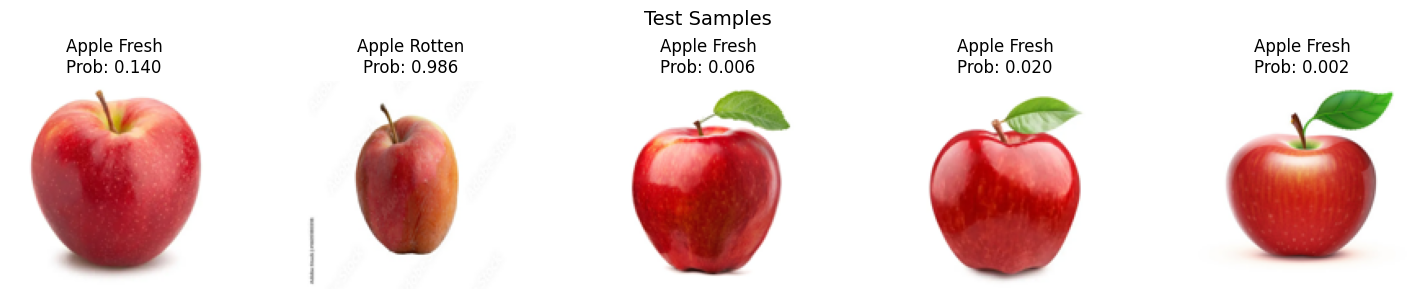

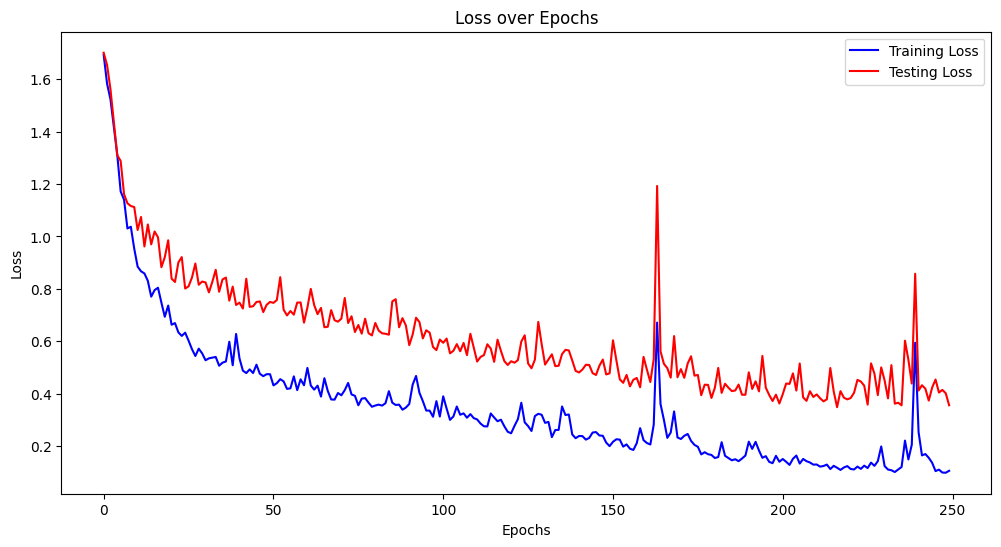

Train Fruit Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       137
      Banana       1.00      1.00      1.00        98
  Strawberry       1.00      1.00      1.00       217

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

Train State Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       306
      Rotten       1.00      1.00      1.00       146

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

Test Fruit Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        42
      Banana       1.00      1.00      1.00        25
  Strawberry       1.00  

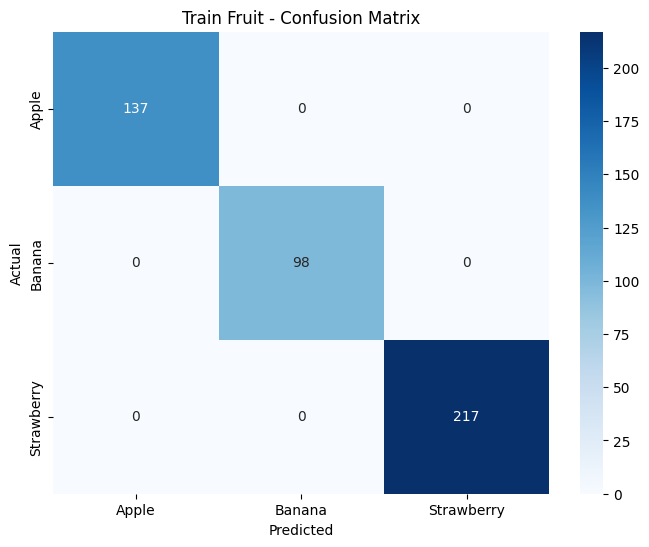

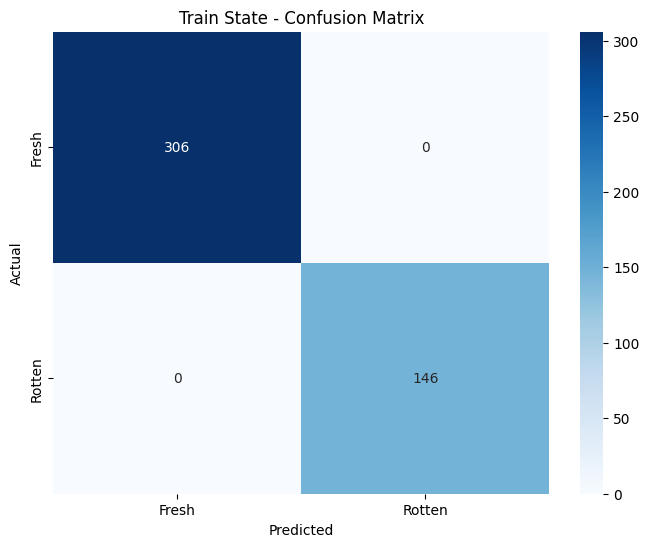

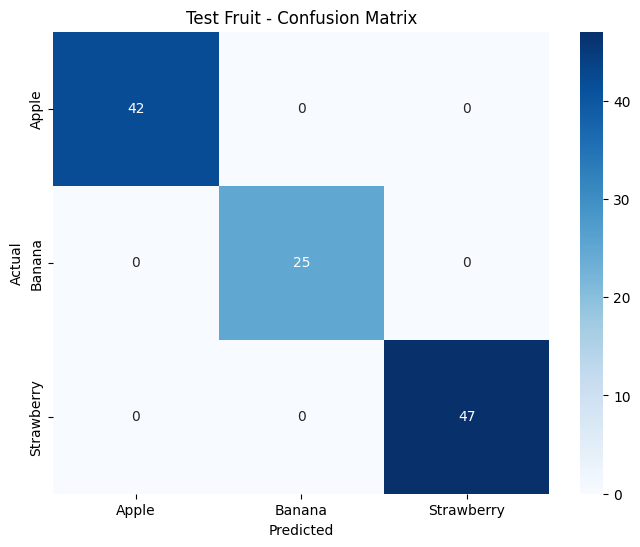

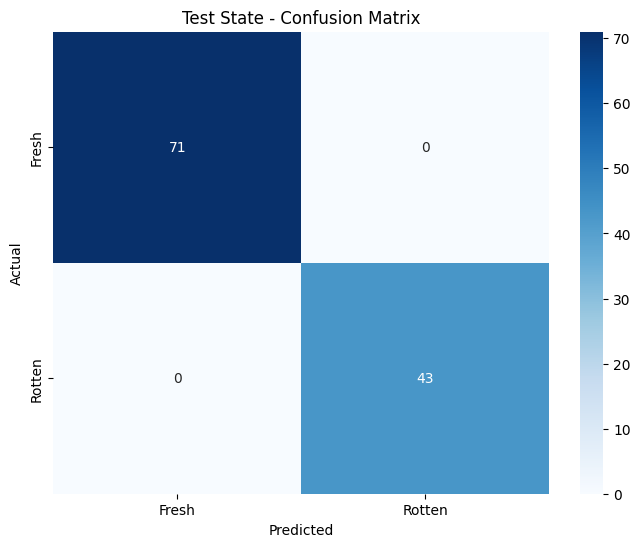

In [28]:
cnn_train = run_cnn(250, "cnn")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


Epoch [10/90], Train Loss: 1.6186, Test Loss: 1.6162
Epoch [20/90], Train Loss: 0.7441, Test Loss: 0.9773
Epoch [30/90], Train Loss: 0.4554, Test Loss: 0.4881
Epoch [40/90], Train Loss: 0.1495, Test Loss: 1.2496
Epoch [50/90], Train Loss: 0.0715, Test Loss: 0.6692
Epoch [60/90], Train Loss: 0.0098, Test Loss: 1.2072
Epoch [70/90], Train Loss: 0.0268, Test Loss: 0.8114
Epoch [80/90], Train Loss: 0.0520, Test Loss: 1.0054
Epoch [90/90], Train Loss: 0.0005, Test Loss: 1.0742

 State Confidence 1 = Rotten, 0 = Fresh


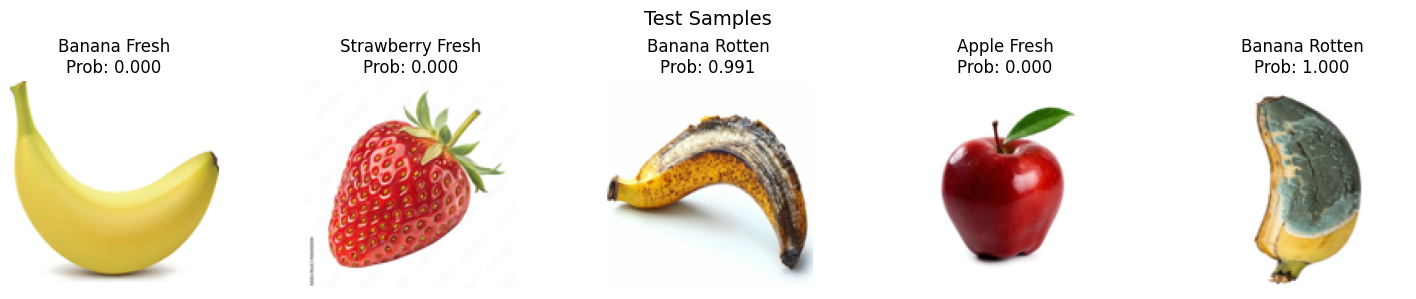

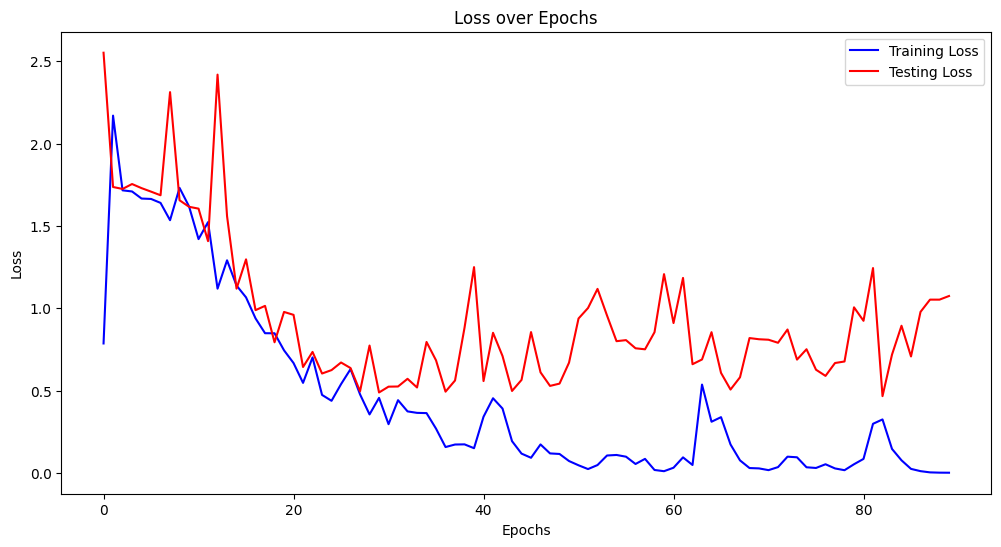

Train Fruit Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00       137
      Banana       1.00      1.00      1.00        98
  Strawberry       1.00      1.00      1.00       217

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

Train State Classification Report:
              precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       306
      Rotten       1.00      1.00      1.00       146

    accuracy                           1.00       452
   macro avg       1.00      1.00      1.00       452
weighted avg       1.00      1.00      1.00       452

Test Fruit Classification Report:
              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        42
      Banana       1.00      1.00      1.00        25
  Strawberry       1.00  

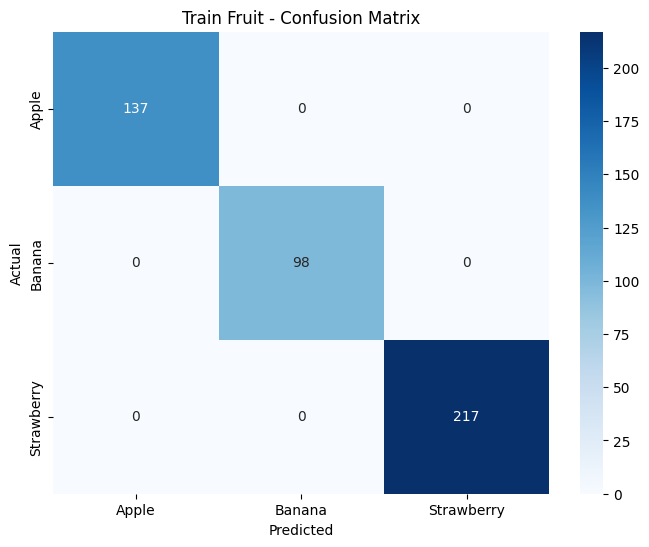

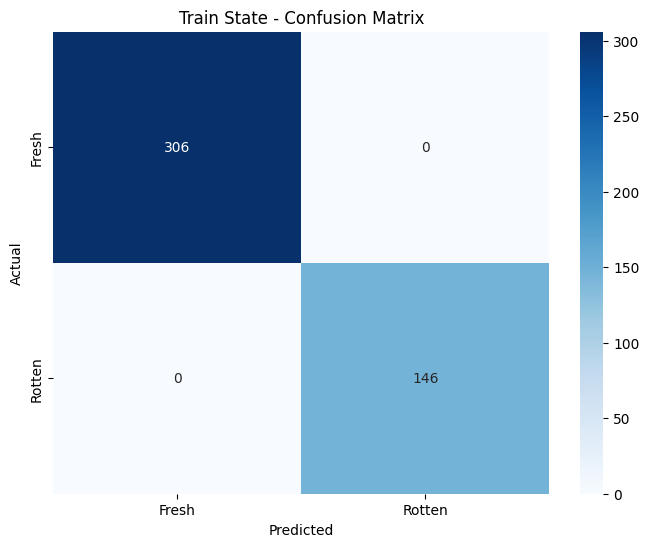

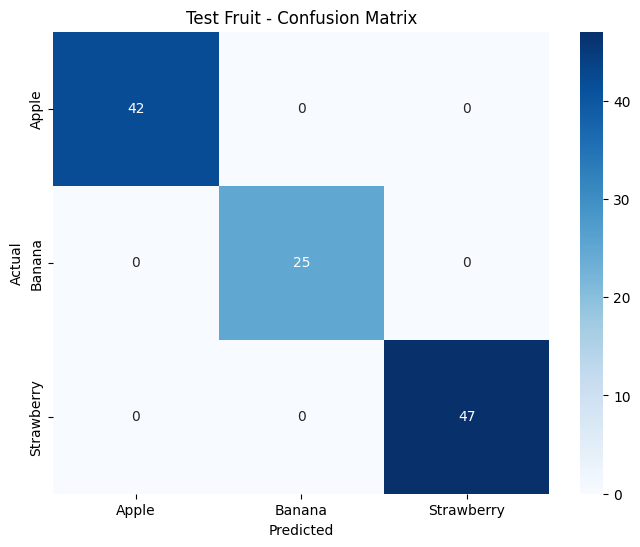

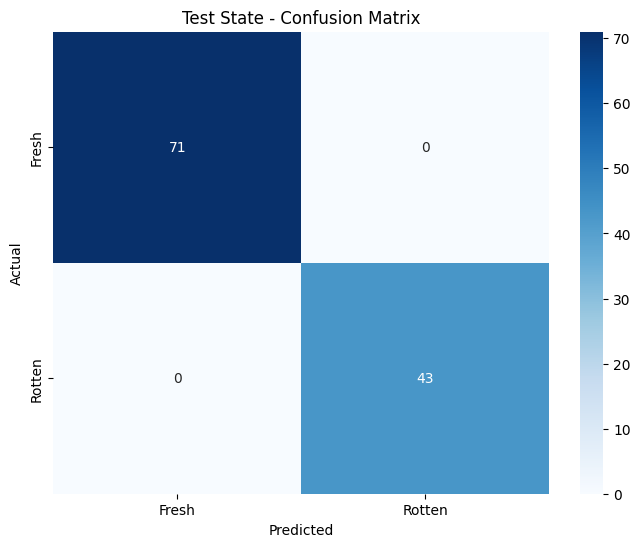

In [29]:
resnet_run = run_cnn(90, "resnet")

## Conclusion

Both CNN models successfully mastered the multi-target task of classifying fruit type and freshness, delivering strong results with over 90% test accuracy and 95% training accuracy. While both demonstrated effective generalization, the ResNet model proved superior by training faster and achieving higher performance in fewer epochs compared to the manual CNN. This efficiency is likely due to ResNet's deep architecture and its ability to learn complex feature representations. Although the project met its goals, future refinements through hyperparameter tuning and optimization could further improve the robustness and fairness of the comparison.